In [1]:
#Import Dependancies 
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
#Import Dependancies
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Use Inspector to See Columns and Data Type

In [9]:
#Use inspector to inspect data columns
inspector = inspect(engine)
# Inspect Measurement
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#Inspect Station
columns2 = inspector.get_columns('Station')
for column in columns2:
    print(column["name"], column["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
maxdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(maxdate)


2017-08-23


In [12]:
# Starting from the most recent data point in the database. 
most_recent = (dt.datetime.strptime(maxdate, "%Y-%m-%d")).date()

# Calculate the date one year from the last date in data set.
year_ago = most_recent - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
percipitation_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
percipitation_df = pd.DataFrame(percipitation_query, columns =["date", "percip"])
percipitation_df.set_index("date", inplace=True)

# Sort the dataframe by date
percipitation_df = percipitation_df.sort_values(["date"])
percipitation_df

,percip
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


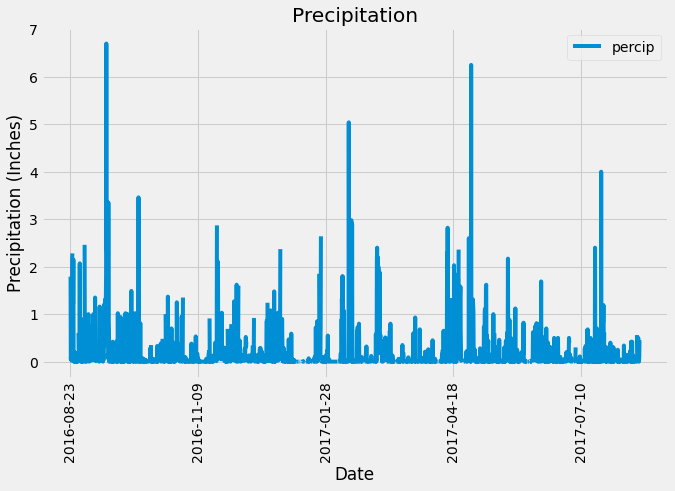

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
percipitation_df.plot.line(y='percip', use_index=True, figsize=(10,6))
pl#Import Dependanciest.xticks(rotation=90)
plt.title("Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.show()

In [14]:
pd.set_option("display.precision", 2)
# Use Pandas to calcualte the summary statistics for the precipitation data
percipitation_df['percip'].agg(['mean', 'median', 'var', 'std', 'sem'])



mean      0.18
median    0.02
var       0.21
std       0.46
sem       0.01
Name: percip, dtype: float64

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
session.query(Station).group_by(Station.station).count()


9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#Isolate the station with the highest activity 
top_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
highest_activity = top_station[0]
# Use Query to pull data calc for most active Station
session.query(Measurement.station, func.avg(Measurement.tobs), func.min(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.station==highest_activity).all()

[('USC00519281', 71.66378066378067, 54.0, 85.0)]

In [18]:
# Using the most active station id

#Query the last 12 months of temperature observation data for this station and 
temp =session.query(Measurement.tobs).filter(Measurement.station==highest_activity).\
    filter(Measurement.date >= year_ago).all()

#Insert data from query into dataframe
temp_df = pd.DataFrame(temp, columns=["Top Observered Temp"])
temp_df.head()

,Top Observered Temp
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


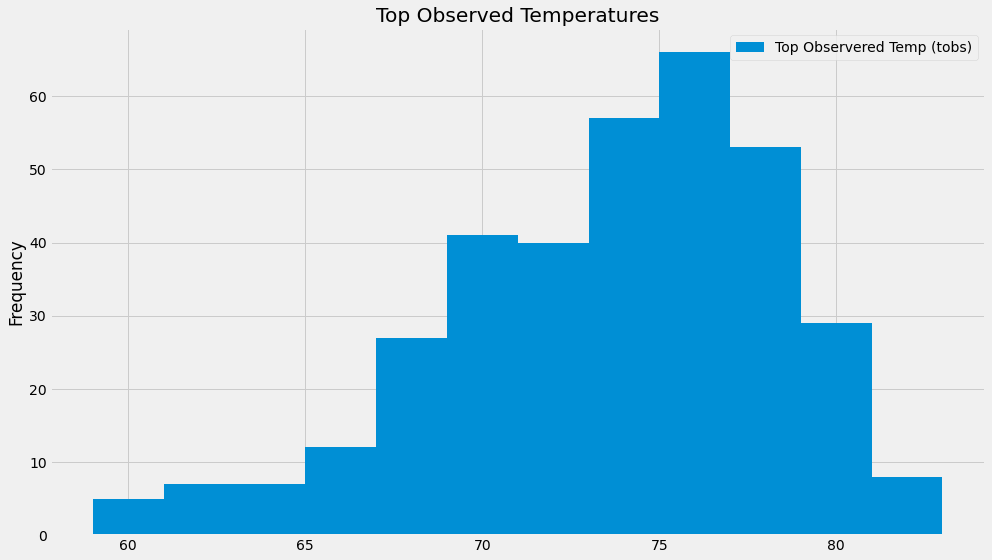

In [22]:
# plot the results as a histogram
plt.figure(figsize=(14,8))
plt.hist(temp_df["Top Observered Temp"], bins=12)
plt.ylabel("Frequency")
plt.title("Top Observed Temperatures")
plt.legend(["Top Observered Temp (tobs)"])
plt.tight_layout()
plt.show()

# Close session

In [20]:
# Close Session
session.close()